In [1]:
# Third party imports
from descartes import PolygonPatch
from geopandas import GeoDataFrame
import json
from lxml import etree
import matplotlib.pyplot as plt 
import numpy as np
import os
import shapely

# Local imports
from product.web_product import WebProduct

%matplotlib inline

# fromDirectory
Creating an instance of WebProduct using formDirectory will gather the timeseries and fault information. The information about download files (filenames, titles, file types, etc.) will be gathered automaticaly unless otherwise specified. Files named timeseries.json, FMM.geojson, and comments.json are written automatically from the original directory. These can be edited before being sent as a product. Consistency of file name conventions can be validated by passing eventid as an argument.

### Note: this assumes only one ffm per event

In [9]:
directory = '../tests/data/timeseries'
product = WebProduct.fromDirectory(directory) 

/Users/hschovanec/Repositories/finite-fault-product/product/web_product.py:424: UserWarning: Missing file 'CMT Solution ' file. Setting to default file path: 'web/CMTSOLUTION'
  'default file path: %r' % (title, default))
/Users/hschovanec/Repositories/finite-fault-product/product/web_product.py:424: UserWarning: Missing file 'Surface Deformation File ' file. Setting to default file path: 'web/.disp'
  'default file path: %r' % (title, default))


## Event information
The event information is contained within a dictionary:

In [10]:
for key in sorted(product.event):
    print(key, product.event[key])

date 2018-05-04 00:00:00
depth 8.0
dx 4.0
dz 2.5
lat 19.37
location HAWAII
lon -155.03
mag 6.88
moment 2.7660745e+19


## Segment information
Segments are provided as a list of dictionaries with the following properties:

In [11]:
for prop in sorted(product.segments)[0].items():
    print(prop[0], ': ', type(prop[1]))

slip :  <class 'numpy.ndarray'>
depth :  <class 'numpy.ndarray'>
length :  <class 'float'>
strike :  <class 'float'>
lon :  <class 'numpy.ndarray'>
dip :  <class 'float'>
lat :  <class 'numpy.ndarray'>
width :  <class 'float'>


## Time series information
Time series are provided as a dictionary of each station with the following properties:

In [12]:
for key in product.timeseries_dict['ANMO']:
    print(key, ': ', type(product.timeseries_dict['ANMO'][key]))
    for value in product.timeseries_dict['ANMO'][key]:
        print('    ', value, ': ', type(product.timeseries_dict['ANMO'][key][value]))
        if isinstance(product.timeseries_dict['ANMO'][key][value], dict):
            for ndarr in product.timeseries_dict['ANMO'][key][value]:
                print('        ', ndarr, ': ', type(product.timeseries_dict['ANMO'][key][value][ndarr]))

metadata :  <class 'dict'>
     station :  <class 'str'>
S :  <class 'dict'>
     synthetic :  <class 'dict'>
         displacement :  <class 'list'>
         time :  <class 'list'>
     data :  <class 'dict'>
         displacement :  <class 'list'>
         time :  <class 'list'>
P :  <class 'dict'>
     synthetic :  <class 'dict'>
         displacement :  <class 'list'>
         time :  <class 'list'>
     data :  <class 'dict'>
         displacement :  <class 'list'>
         time :  <class 'list'>
Z :  <class 'dict'>
     synthetic :  <class 'dict'>
         displacement :  <class 'list'>
         time :  <class 'list'>
     data :  <class 'dict'>
         displacement :  <class 'list'>
         time :  <class 'list'>
T :  <class 'dict'>
     synthetic :  <class 'dict'>
         displacement :  <class 'list'>
         time :  <class 'list'>
     data :  <class 'dict'>
         displacement :  <class 'list'>
         time :  <class 'list'>


### The timeseries metadata and comments
At this time the time series metadata only contains the station name. Network, location, channel, and starttime are things that should be added in the future. Comments are class properties that will be included in the fault geojson.

In [13]:
print(product.timeseries_dict['ANMO']['metadata'])
print(product.analysis)
print(product.result)
print(product.inversion_process)

{'station': 'ANMO'}
['This model still needs work, but the observation of slip aligned on a shallowly dipping plane beneath the rift and the bulk of the EQs seems consistent. Here, I have assumed a depth of 8 km, and resolve slip onto the shallow plane of the updated USGS W-phase moment tensor. Slip after ~25 s is poorly constrained and probably noise. Preliminary GPS data suggests slip may not extend NE of the hypocenter, but I have not constrained the fault plane to eliminate that possibility here.\n']
['After comparing waveform fits based on the two planes of the input moment tensor, we find that the nodal plane (strike= 240.0 deg., dip= 20.0 deg.) fits the data better. The seismic moment release based upon this plane is 2.8e+26 dyne.cm (Mw = 6.9) using a 1D crustal model interpolated from CRUST2.0 (Bassin et al., 2000).\n']
['We used GSN and FDSN broadband waveforms downloaded from the NEIC waveform server. We analyzed 42 teleseismic broadband P waveforms, 28 broadband SH waveforms

## The time series web product
The time series web product should be the same as the timeseries dictionary with the addition of the metadata. Once the location information for each station is added, each station will become it's own point feature in the geojson, which the time series as properties. This will be done using a method called something similar to `formatTimeseriesGeojson`

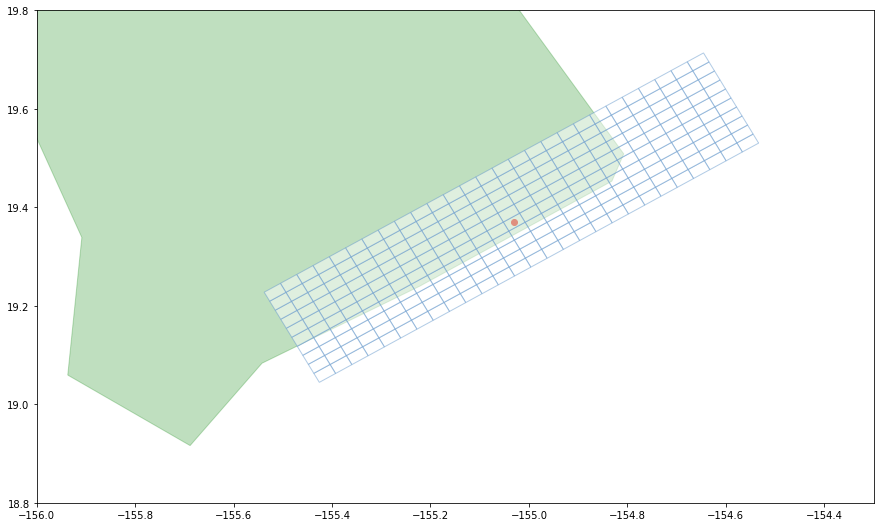

In [14]:
with open('segment_grid.json', 'wt') as out:
    res = json.dump(product.grid, out, sort_keys=True, indent=4)

segments = GeoDataFrame.from_file('segment_grid.json')
countries = GeoDataFrame.from_file('uscountries.json')
gavin_corners = GeoDataFrame.from_file('gh_corners.json')
os.remove('segment_grid.json') 

BLUE = '#6699cc'
GREEN = '#008000'
fig = plt.figure(figsize=(15,10)) 
ax = fig.gca()
for country in countries['geometry']:
    ax.add_patch(PolygonPatch(country, fc=GREEN, ec=GREEN, alpha=0.25, zorder=2 ))
for poly in segments['geometry']:
    if isinstance(poly, shapely.geometry.polygon.Polygon):
        ax.add_patch(PolygonPatch(poly, fc='#ffffff', ec=BLUE, alpha=0.5, zorder=2 ))
    else:
        earthquake = (poly.x, poly.y)
ax.scatter(earthquake[0], earthquake[1], c='r')
ax.axis('scaled')
ax.set_xlim(-156, -154.3)
ax.set_ylim(18.8, 19.8)
plt.show()

## Contents.xml


In [15]:
product.createContents(directory)
print(etree.tostring(product.contents ,pretty_print=True).decode())

<contents>
  <file id="basemap" title="Base Map ">
    <caption><![CDATA[Map of finite fault showing it's geographic context ]]></caption>
    <format href="web/1000dyad_basemap.png" type="image/png"/>
  </file>
  <file id="cmtsolution1" title="CMT Solution ">
    <caption><![CDATA[Full CMT solution for every point in finite fault region ]]></caption>
    <format href="web/CMTSOLUTION" type="text/plain"/>
  </file>
  <file id="inpfile1_1" title="Inversion Parameters File 1 ">
    <caption><![CDATA[Basic inversion parameters for each node in the finite fault ]]></caption>
    <format href="web/1000dyad.param" type="text/plain"/>
  </file>
  <file id="inpfile2_1" title="Inversion Parameters File 2 ">
    <caption><![CDATA[Complete inversion parameters for the finite fault, following the SRCMOD FSP format (http://equake-rc.info/) ]]></caption>
    <format href="web/1000dyad.fsp" type="text/plain"/>
  </file>
  <file id="coulomb_1" title="Coulomb Input File ">
    <caption><![CDATA[Format 